In [73]:
import os
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
import os
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms

In [74]:
script_dir = os.getcwd()
emotion_processor = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression")
multi_face_model = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")

scene_weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
scene_checkpoint = torch.hub.load_state_dict_from_url(scene_weights_url, map_location="cpu")

original_scene_model = models.resnet18(num_classes=365)
original_scene_model.fc = nn.Linear(original_scene_model.fc.in_features, 365)
scene_state_dict = {k.replace("module.", ""): v for k, v in scene_checkpoint["state_dict"].items()}
original_scene_model.load_state_dict(scene_state_dict)
original_scene_model.eval()

# Preprocessing, the standard torchvision normalization for ResNet, VGG, DenseNet...
scene_tf = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]

In [75]:
from deepproblog.network import Network 
import torch.nn.functional as F

original_hf_emotion_model = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")

class MultiFaceWrapperFlat(nn.Module):
    def __init__(self, hf_model, max_faces=10):
        super().__init__()
        self.hf_model = hf_model
        self.max_faces = max_faces

    def forward(self, x):
        if isinstance(x, list) and len(x) == 1 and isinstance(x[0], list):
            face_tensors = x[0]
        elif isinstance(x, list):
            face_tensors = x
        else:
            face_tensors = [x]
        
        face_probs_list = []
        
        # Process up to max_faces
        for i, face_tensor in enumerate(face_tensors[:self.max_faces]):
            if torch.is_tensor(face_tensor):
                face_batch = face_tensor.unsqueeze(0)
                outputs = self.hf_model(face_batch)
                probs = F.softmax(outputs.logits, dim=-1)
                face_probs_list.append(probs.squeeze(0)) 
        
        # Pad with zeros if fewer faces than max_faces
        while len(face_probs_list) < self.max_faces:
            face_probs_list.append(torch.zeros(7))
        
        # Flatten: [max_faces * 7] = [70] for 10 faces
        result = torch.cat(face_probs_list, dim=0)
        return result

# Replace your multi_face_model
max_faces = 5
multi_face_model = MultiFaceWrapperFlat(original_hf_emotion_model, max_faces=max_faces)

# Update the network
multi_face_network = Network(multi_face_model, "multi_face_net", batching=False)
    
class SceneWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        if isinstance(x, list):
            x = torch.stack(x, dim=0)
        elif len(x.shape) == 3:
            x = x.unsqueeze(0)
            
        logits = self.model(x)
        probs = F.softmax(logits, dim=-1)
        return probs

scene_model = SceneWrapper(original_scene_model)
scene_network = Network(scene_model, "scene_net", batching=False)

In [76]:
import os
import pandas as pd
import random
from io import StringIO
import matplotlib.pyplot as plt
from IPython.display import display
import random
import matplotlib.pyplot as plt
import cv2
from PIL import Image

script_dir = os.getcwd()
labels_dir = os.path.join(script_dir, "../data/findingemo/labels")
base_findingemo_dir = os.path.join(script_dir, "../data/findingemo")
csv_path = os.path.join(labels_dir, "annotations_cleaned.csv")
df_findingEmo = pd.read_csv(csv_path)

In [77]:
# train_test split
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_findingEmo, test_size=0.2, random_state=42)

# reset indexes
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [78]:
from mtcnn import MTCNN
# Image access (tensors) - separate classes for different preprocessing
class FindingEmoFaceImages(object):
    def __init__(self, subset, print_cropped=False):
        self.subset = subset
        self.face_detector = MTCNN()
        self.print_cropped = print_cropped

        if self.subset == "train":
            self.dataframe = train_df.copy()
        else:
            self.dataframe = test_df.copy()
# Will return a list of tensors corresponding to all the detected faces.
# If no face is detected, just return the tensor of the image.
    def __getitem__(self, item):
        index = int(item[0]) if isinstance(item, (tuple, list)) else int(item)
        
        image_path = self.dataframe["image_path"][index]
        if image_path.startswith('/'):
            image_path = image_path[1:]
        
        img_path = os.path.join(base_findingemo_dir, image_path)
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Detect the faces
        face_results = self.face_detector.detect_faces(img)

        # Sort faces by x-coordinate (left to right)
        if len(face_results) > 0:
            face_results.sort(key=lambda face: face['box'][0])

        # Only max faces
        face_results = face_results[:max_faces]

        face_tensors = []
        face_pils = []

        if len(face_results) > 0:
            for face_result in face_results:
                x, y, w, h = face_result['box']

                # Handle negative coordinates and bounds
                x = max(0, x)
                y = max(0, y)
                x2 = min(img.shape[1], x + w)
                y2 = min(img.shape[0], y + h)

                # Face crop
                face_crop = img[y:y2, x:x2] 
                # Skip if the crop is too small
                if face_crop.shape[0] < 10 or face_crop.shape[1] < 10:
                    continue

                # Converting to PIL and process it with HF processor
                face_pil = Image.fromarray(face_crop)
                face_pils.append(face_pil)
                face_input = emotion_processor(images=face_pil, return_tensors="pt")
                face_tensors.append(face_input['pixel_values'].squeeze(0))

        if len(face_tensors) == 0:
            # Use whole image as fallback
            img_pil = Image.fromarray(img)
            face_input = emotion_processor(images = img_pil, return_tensors="pt")
            face_tensors.append(face_input['pixel_values'].squeeze(0))

        if self.print_cropped:
            # Display cropped faces
            num_faces = len(face_pils)
            if num_faces > 0:
                plt.figure(figsize=(8, 3))
            for i, face_pil in enumerate(face_pils):
                plt.subplot(1, num_faces, i + 1)
                plt.imshow(face_pil)
                plt.title(f'Face {i}')
                plt.axis('off')
            plt.show()
            
            self.print_cropped = False
            
        return face_tensors

class FindingEmoSceneImages(object):
    def __init__(self, subset):
        self.subset = subset
        if self.subset == "train":
            self.dataframe = train_df.copy()
        else:
            self.dataframe = test_df.copy()
            
    def __getitem__(self, item):
        index = int(item[0]) if isinstance(item, (tuple, list)) else int(item)
        
        image_path = self.dataframe["image_path"][index]
        if image_path.startswith('/'):
            image_path = image_path[1:]
        
        img_path = os.path.join(base_findingemo_dir, image_path)
        
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")
            
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Failed to load image: {img_path}")
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img)
        
        # Use scene transforms for scene model
        scene_tensor = scene_tf(img_pil)
        return scene_tensor

# Create separate instances
FindingEmoFace_train = FindingEmoFaceImages("train", print_cropped=True)
FindingEmoFace_test = FindingEmoFaceImages("test")
FindingEmoScene_train = FindingEmoSceneImages("train") 
FindingEmoScene_test = FindingEmoSceneImages("test")

In [79]:
emotion_categories = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

In [82]:
# Mapping for the scene categories. Read them from ../data/places365/categories_places365.txt
scene_categories = []
with open(os.path.join(script_dir, "../data/places365/categories_places365.txt")) as f:
    for line in f:
        scene = line.strip().split(' ')[0][3:]
        scene_categories.append(scene)

model_scene_to_index = {scene: idx for idx, scene in enumerate(scene_categories)}

In [83]:
from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.engines import ExactEngine
from deepproblog.dataset import Dataset, DataLoader
from torch.utils.data import Dataset as TorchDataset
from problog.logic import Term, Constant, Var
from deepproblog.query import Query
from deepproblog.train import train_model

In [84]:
num_emotions = len(emotion_categories) * max_faces
num_scenes = len(scene_categories)

emotion_indices = list(range(num_emotions))
scene_indices = list(range(num_scenes))

In [85]:
prolog = f"""
% Neural networks - flattened tensor approach
% Face emotions: 5 faces x 7 emotions = 35 total indices (0 to 34)
nn(multi_face_net, [X], Y, {emotion_indices}) :: all_face_emotions(X, Y).

% Scene prediction: 365 scene categories (keeping first 10 for testing)
nn(scene_net, [X], Y, {scene_indices}) :: scene_prediction(X, Y).

% Extract individual face-emotion probability from flattened tensor
% FlatIndex = FaceIndex * 7 + EmotionIndex
face_emotion_prob(Image, FaceIdx, EmotionIdx) :-
    FlatIdx is FaceIdx * {len(emotion_categories)} + EmotionIdx,
    FlatIdx >= 0, FlatIdx =< {num_emotions - 1},  % Safety bounds
    all_face_emotions(Image, FlatIdx).

% Get dominant emotion for a specific face
dominant_face_emotion(Image, FaceIdx, EmotionIdx) :-
    FaceIdx >= 0, FaceIdx =< {max_faces - 1},  % Max 5 faces
    EmotionIdx >= 0, EmotionIdx =< {len(emotion_categories) - 1},
    face_emotion_prob(Image, FaceIdx, EmotionIdx),
    % Check this is the highest probability for this face
    \+ (between(0, {len(emotion_categories) - 1}, OtherEmotion),
        OtherEmotion \= EmotionIdx,
        face_emotion_prob(Image, FaceIdx, OtherEmotion),
        face_emotion_prob(Image, FaceIdx, OtherEmotion) > face_emotion_prob(Image, FaceIdx, EmotionIdx)).

% Simple query: just get the raw tensor output from neural network
faces(FaceImg, AllEmotions) :-
    all_face_emotions(FaceImg, AllEmotions).

% Scene prediction 
scene(SceneImg, SceneIdx) :-
    scene_prediction(SceneImg, SceneIdx).

% Simple rule combining face and scene for joint training
happy_prediction(Image) :-
    dominant_face_emotion(Image, _, 3),  % Face shows happy (emotion index 3)
    scene_prediction(Image, _).          % Any scene (for now)

% Emotion name mapping
emotion_name(0, angry).
emotion_name(1, disgust).
emotion_name(2, fear).
emotion_name(3, happy).
emotion_name(4, sad).
emotion_name(5, surprise).
emotion_name(6, neutral).
"""

# Write the integrated Prolog file
with open(os.path.join(script_dir, "model.pl"), "w") as f:
    f.write(prolog)

In [86]:
train_indices = list(range(len(train_df))) 
test_indices = list(range(len(test_df))) 

In [87]:

# Create model
model = Model(
    os.path.join(script_dir, "model.pl"),
    [multi_face_network, scene_network]
)
model.set_engine(ExactEngine(model), cache=True)

# Register tensor sources
model.add_tensor_source("train_face", FindingEmoFace_train)
model.add_tensor_source("test_face", FindingEmoFace_test)
model.add_tensor_source("train_scene", FindingEmoScene_train)
model.add_tensor_source("test_scene", FindingEmoScene_test)

Caching ACs


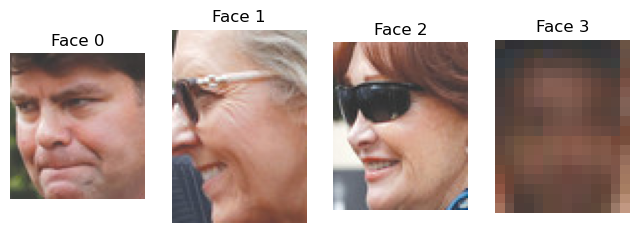

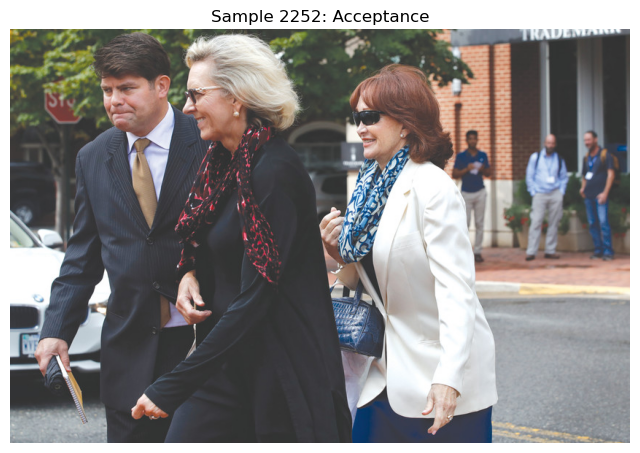

Number of detected faces: 4

FACE 0:
----------------------------------------
   angry   : 0.680
   disgust : 0.210
   fear    : 0.082
   surprise: 0.021
   neutral : 0.005
   sad     : 0.001
   happy   : 0.001

FACE 1:
----------------------------------------
   happy   : 0.994
   neutral : 0.003
   angry   : 0.001
   disgust : 0.001
   sad     : 0.001
   surprise: 0.000
   fear    : 0.000

FACE 2:
----------------------------------------
   happy   : 0.994
   sad     : 0.002
   neutral : 0.001
   surprise: 0.001
   disgust : 0.001
   fear    : 0.000
   angry   : 0.000

FACE 3:
----------------------------------------
   fear    : 0.332
   angry   : 0.238
   surprise: 0.187
   happy   : 0.140
   neutral : 0.051
   sad     : 0.042
   disgust : 0.011
Ground Truth Emotion: ACCEPTANCE

FACE 0:
----------------------------------------
   angry   : 0.680
   disgust : 0.210
   fear    : 0.082
   surprise: 0.021
   neutral : 0.005
   sad     : 0.001
   happy   : 0.001

FACE 1:
---------------

In [ ]:
# Simple test showing only distributions
train_sample_idx = random.randint(0, len(train_df) - 1)
face_tensors = FindingEmoFace_train[(train_sample_idx,)]

# display original image
img_path = os.path.join(base_findingemo_dir, train_df.iloc[train_sample_idx]['image_path'])
img = cv2.imread(img_path)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.imshow(img_rgb)
plt.axis('off')
plt.title(f"Sample {train_sample_idx}: {train_df.iloc[train_sample_idx]['emotion']}")
plt.show()

print(f"Number of detected faces: {len(face_tensors)}")

# Face emotion distributions using DeepProbLog query
face_query = Query(
    Term("faces",
         Term("tensor", Term("train_face", Constant(train_sample_idx))),
         Var("AllEmotions")),
    substitution={}
)

face_results = model.solve([face_query])
face_result_dict = face_results[0].result

# Extract probability values in order (indices 0-34)
emotion_probs = []
for i in range(max_faces * len(emotion_categories)):  # 5 faces × 7 emotions
    key_found = False
    for key, prob in face_result_dict.items():
        # Extract index from the key string like "faces(tensor(train_face(1234)),5)"
        if str(key).endswith(f",{i})"):
            emotion_probs.append(prob)
            key_found = True
            break
    if not key_found:
        emotion_probs.append(0.0)  # Default if key not found

for face_idx in range(max_faces):
    start_idx = face_idx * 7
    end_idx = start_idx + 7
    face_emotion_probs = emotion_probs[start_idx:end_idx]
    
    # Check if this face has any non-zero probabilities (i.e., face exists)
    if sum(face_emotion_probs) > 0.01:  # Threshold to detect if face exists
        print(f"\nFACE {face_idx}:")
        print("-" * 40)
        
        # Create list of (emotion, probability) pairs and sort by probability
        emotion_prob_pairs = [(emotion_categories[i], prob) for i, prob in enumerate(face_emotion_probs)]
        emotion_prob_pairs.sort(key=lambda x: x[1], reverse=True)
        
        # Display emotions sorted from highest to lowest confidence
        for emotion, prob in emotion_prob_pairs:
            print(f"   {emotion:8}: {prob:.3f}")
    else:
        # Face slot is empty (padded with zeros)
        if face_idx >= len(face_tensors):
            break  # Stop showing empty slots

print(f"Ground Truth Emotion: {train_df.iloc[train_sample_idx]['emotion'].upper()}")